In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm

In [2]:
data_dir0 = '../data/lunar/training/'

catalog_directory = '../data/lunar/training/catalogs/'
catalog_file = 'apollo12_catalog_GradeA_final.csv'
catalog = pd.read_csv(catalog_directory + catalog_file)

In [3]:
import random
i = random.randint(1, len(catalog) - 1)
row = catalog.iloc[i]
test_filename = row.filename

data_directory = data_dir0 + 'data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

In [7]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import itertools


def find_clusters(hf_points, _min_dist = 2000):

    X = np.array(hf_points).reshape(-1, 1)  

    initial_n_clusters = 5 
    kmeans = KMeans(n_clusters=initial_n_clusters)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_

    def filter_centroids(centroids, min_distance):
        filtered_centroids = []
        
        for centroid in centroids:
            if all(np.linalg.norm(centroid - other) >= min_distance for other in filtered_centroids):
                filtered_centroids.append(centroid)
        
        return np.array(filtered_centroids)

    filtered_centroids = filter_centroids(centers, _min_dist)

    return filtered_centroids


def a(f=0, i=0, _STA=120, _LTA=600, _thr_on = 2.0, _thr_off = 1.5, _minfreq_filter=0.8, _maxfreq_filter=1, triggerPlot=False,
      _high_freq_thresh=0.05, _power_thresh=0.4,):
    
    #for i in range(1,len(cat)):
    for i2 in range(1,2):

        #i = random.randint(1, len(cat) - 1)
        row = catalog.iloc[i]
        test_filename = row.filename

        data_directory = data_dir0 + 'data/S12_GradeA/'
        mseed_file = f'{data_directory}{test_filename}.mseed'
        


        #print(catalog.loc[catalog['filename'] == test_filename])
        act_quake_cat = catalog.loc[catalog['filename'] == test_filename, 'time_rel(sec)'].values[0]
        #print(act_quake_cat)

        try:
            st = read(mseed_file)
        except FileNotFoundError:
            print(f"File {mseed_file} not found. Skipping to next iteration.")
            continue


        # This is how you get the data and the time, which is in seconds

        if(f==0):
            tr = st.traces[0].copy()
            tr_times = tr.times()
            tr_data = tr.data
        else:
            minfreq = _minfreq_filter
            maxfreq = _maxfreq_filter
            st_filt = st.copy()

            #st_filt.filter('bandpass',freqmin=_minfreq_filter,freqmax=_maxfreq_filter)
            st_filt.filter('lowpass',freq=_maxfreq_filter)
            st_filt.filter('highpass',freq=_minfreq_filter)

            tr_filt = st_filt.traces[0].copy()
            tr_times_filt = tr_filt.times()
            tr_data_filt = tr_filt.data
            # This is how you get the data and the time, which is in seconds
            tr = tr_filt.copy()
            tr_times = tr_times_filt.copy()
            tr_data = tr_data_filt.copy()

        fp, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate, nperseg=256, noverlap=128, scaling='density')
        vmax = sxx.max()
        vmin = sxx.min()

        # Sampling frequency of our trace
        df = tr.stats.sampling_rate

        sta_len = _STA
        lta_len = _LTA

        # Run Obspy's STA/LTA to obtain a characteristic function
        # This function basically calculates the ratio of amplitude between the short-term 
        # and long-term windows, moving consecutively in time across the data
        cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

        # Plot characteristic function
        fig, (ax, ax1 ,ax2) = plt.subplots(3, 1, figsize=(12, 8))
        
        if (triggerPlot == True):
            thr_on = _thr_on
            thr_off = _thr_off
            on_off = np.array(trigger_onset(cft, thr_on, thr_off))
            # The first column contains the indices where the trigger is turned "on". 
            # The second column contains the indices where the trigger is turned "off".

            for i in np.arange(0,len(on_off)):
                triggers = on_off[i]
                ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
                ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')
    
        ax.plot(tr_times,tr_data)
        ax.set_xlim([min(tr_times),max(tr_times)])
        ax.set_ylabel('Velocity (m/s)')
        #ax.set_xlabel('Time (s)')
        ax.set_title('Unfiltered' if f == 0 else f'Filtered - bandpass [{minfreq}-{maxfreq}]')
        #ax.set_title(f'{test_filename}', fontweight='bold') 
        ax.axvline(x=act_quake_cat, c='red')

        # Plot characteristic function
        ax1.plot(tr_times, cft)
        #ax1.set_title('Unfiltered' if f == 0 else f'Filtered - bandpass [{minfreq} {maxfreq}]')
        ax1.set_xlim([min(tr_times), max(tr_times)])
        #ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Characteristic function')
        ax1.axvline(x=act_quake_cat, c='red')
        #ax1.legend()

        ## Plot spectrogram
        vals = ax2.pcolormesh(t, fp, sxx, cmap=cm.jet, vmin = vmin, vmax=vmax)
        #vals = ax2.pcolormesh(t, fp, sxx, cmap=cm.jet, vmin = 0, vmax=1)

        ax2.set_xlim([min(tr_times), max(tr_times)])
        ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
        ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
        ax2.axvline(x=act_quake_cat, c='red', linewidth=1)

        cbar = plt.colorbar(vals, ax=ax2, orientation='horizontal')
        cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

        # Normalize fp and sxx
        fp = (fp - np.min(fp)) / (np.max(fp) - np.min(fp))
        sxx = (sxx - np.min(sxx)) / (np.max(sxx) - np.min(sxx))  

        high_freq_mask = fp >= _high_freq_thresh  # Mask for high frequencies
        high_power_mask = sxx > _power_thresh    # Mask for sections with high power
        # Combined mask for high-frequency and high-power regions
        combined_mask = np.logical_and(high_freq_mask[:, None], high_power_mask)
        # Extract high-frequency sections
        high_freq_sections = []
        for i in range(sxx.shape[1]):  # Iterate over time steps
            high_freqs_at_t = fp[combined_mask[:, i]]  # Extract frequencies for time step i
            if len(high_freqs_at_t) > 0:
                high_freq_sections.append((t[i], high_freqs_at_t))

        
        if len(high_freq_sections) > 0:

            hf_points = [row[0] for row in high_freq_sections]
            centers = find_clusters(hf_points)
            min_values = list(itertools.chain.from_iterable(centers))

            for v in min_values:
                ax2.axvline(x=v, c='yellow', linewidth=1)
                ax.axvline(x=v-2500, c='blue', linewidth=4)
                ax.axvline(x=min((v+6500),(tr_times[-1]-100)), c='blue', linewidth=4)

        return fp, t, sxx


1 Trace(s) in Stream:
XA.S12.00.MHZ | 1974-02-12T00:00:00.400000Z - 1974-02-13T00:00:02.513208Z | 6.6 Hz, 572415 samples


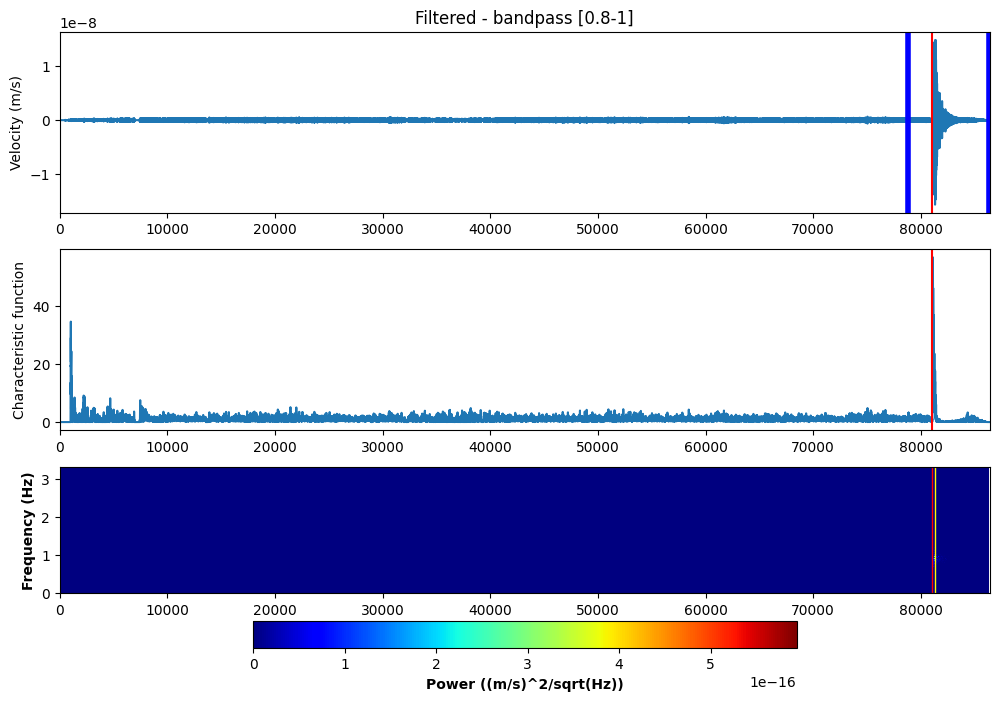

In [8]:
for j in range(1,2):
    
    i = random.randint(1, len(catalog) - 1)

    # STA/LTA params
    sta = 10
    lta= 1000
    thr_on = 2.5
    thr_off = 1
    # FILTER applied, bandpass (actually it's a LowPass first with cutoff = max and then HighPass with cutoff = 0.8)
    min_cut = 0.8
    max_cut = 1
    # Spectrogram filtering (and then k-means) params. They are applied on normalized freq and power values (inside).
    high_freq_thresh = 0.2
    power_thresh = 0.4

    #a(0,i,sta, lta, _thr_on = thr_on, _minfreq_filter = min_cut, _maxfreq_filter = max_cut, triggerPlot=False)    
    a(1,i,sta, lta, _thr_off = thr_off, _minfreq_filter = min_cut, _maxfreq_filter = max_cut,
                 _high_freq_thresh = high_freq_thresh, _power_thresh = power_thresh)


In [ ]:
#-------------------------------------------------------------------------------------------------------------